# Chapter 6: Calculating local densities

We may want to analyze our data in dependence of local densities. For this, midap-tools comes with a method of calculating local densities from the segment maps

What midap tools does is:
-   for each cell at each frame fetches the x and y coordinate of the cell center
-   loads segment maps for all channels at this frame
-   defines an interaction zone around the center of the cell with a given radius
-   calculates the density of each color_channel within this interaction zone
-   midap-tools will ignore area outside the image (i.e if a cell is situated in a corner, the density will be calcualted in the remaining pie-section only)

Lets start by loading a new experiment

In [1]:
from fluid_experiment.fluid_experiment import FluidExperiment

PATH = "../../data/midap-tools_example"
experiment = FluidExperiment(PATH, name= "example_experiment")
experiment.load_metadata_template()
print(experiment)

Loading sample at position pos1 for color channel YFP
Loading sample at position pos1 for color channel CFP
Loading sample at position pos2 for color channel YFP
Loading sample at position pos2 for color channel CFP
Loading sample at position pos3 for color channel YFP
Loading sample at position pos3 for color channel CFP
Loading sample at position pos4 for color channel YFP
Loading sample at position pos4 for color channel CFP
Loading sample at position pos5 for color channel YFP
Loading sample at position pos5 for color channel CFP
Loading sample at position pos6 for color channel YFP
Loading sample at position pos6 for color channel CFP
Successfully loaded data with consistent number of frames: 143
FluidExperiment with name: example_experiment
Path: ../../data/midap-tools_example
6 positions: pos1, pos2, pos3, pos4, pos5, pos6
2 color channels: YFP, CFP
length of experiment is consistent: 143
experiment has consistent headers: Unnamed: 0, globalID, frame, labelID, trackID, lineageID

***

## Calculate local neighborhood

Next, we initialize a local neighborhood analysis using the following command:

We use a distance threshold of 50px, so the densities will be calculated within a circle of 50px around our cells

In [2]:
experiment.calculate_local_neighborhood(distance_threshold=50)
print(experiment)

Calculating neighborhoods of all channels in a radius of 50 px
Calculate neighborhoods for position pos1
Calculate neighborhoods for position pos2
Calculate neighborhoods for position pos3
Calculate neighborhoods for position pos4
Calculate neighborhoods for position pos5
Calculate neighborhoods for position pos6
FluidExperiment with name: example_experiment
Path: ../../data/midap-tools_example
6 positions: pos1, pos2, pos3, pos4, pos5, pos6
2 color channels: YFP, CFP
length of experiment is consistent: 143
experiment has consistent headers: Unnamed: 0, globalID, frame, labelID, trackID, lineageID, trackID_d1, trackID_d2, split, trackID_mother, first_frame, last_frame, area, edges_min_row, edges_min_col, edges_max_row, edges_max_col, intensity_max, intensity_mean, intensity_min, minor_axis_length, major_axis_length, x, y, density_YFP, density_CFP
Experiment has metadata:
         position   group          experiment  device_channel
position                                              

***

as we note, the operation created two new data columns, `density_YFP` and `density_CFP`

lets use a spatial map to visualize the densities

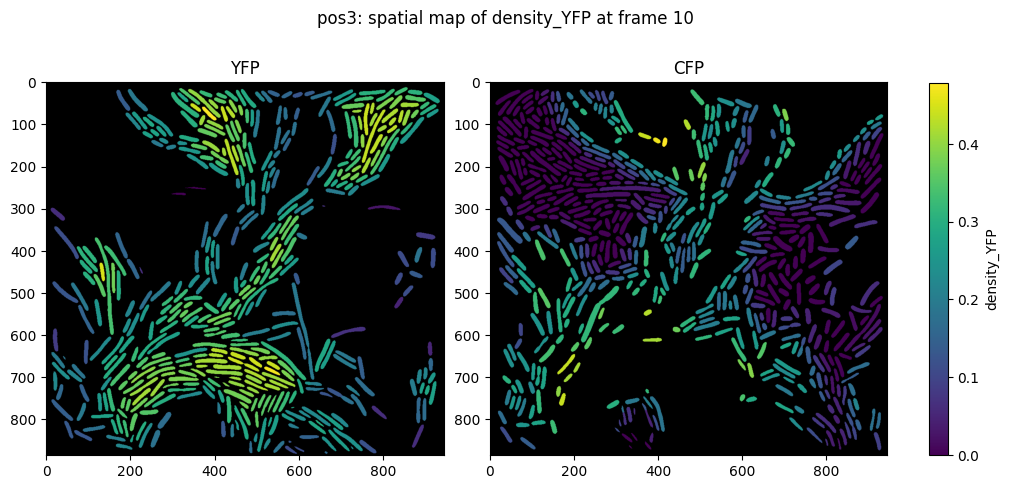

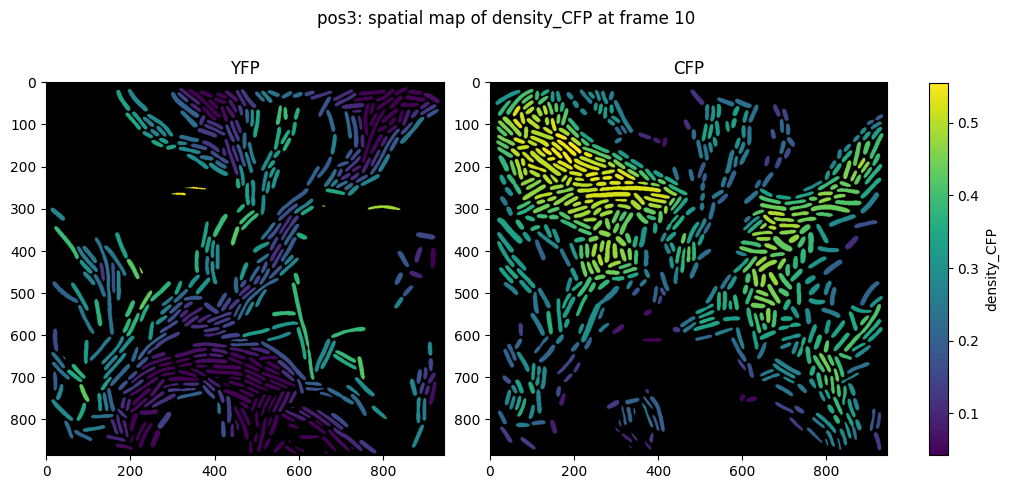

In [3]:
experiment.plot_spatial_maps(frame=10,property_column="density_YFP", positions= "pos3")
experiment.plot_spatial_maps(frame=10,property_column="density_CFP", positions= "pos3")

***

The current calculation does take empty space into consideration, so a isolated cell will have a very low density of any neighbor by default. This also means that the sum of all densities can be less than 1

lets look at an example with such empty regions

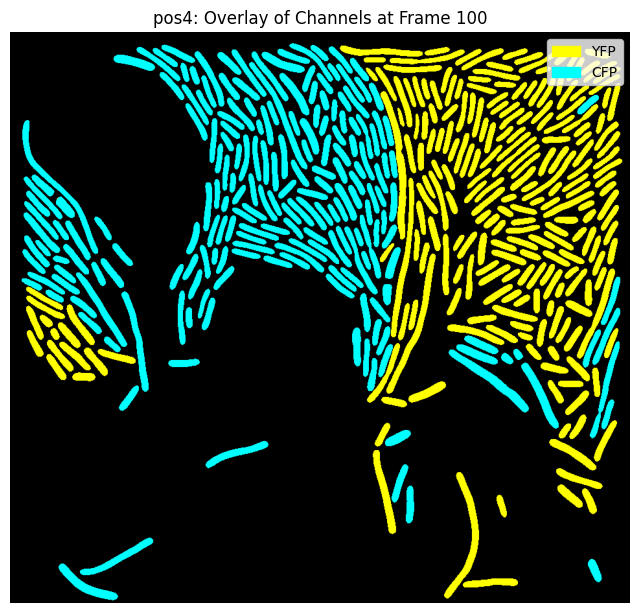

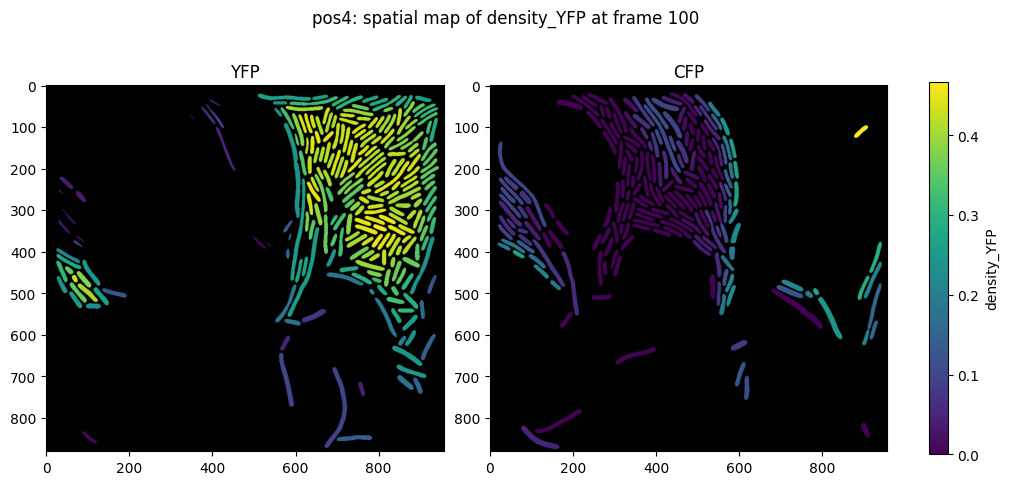

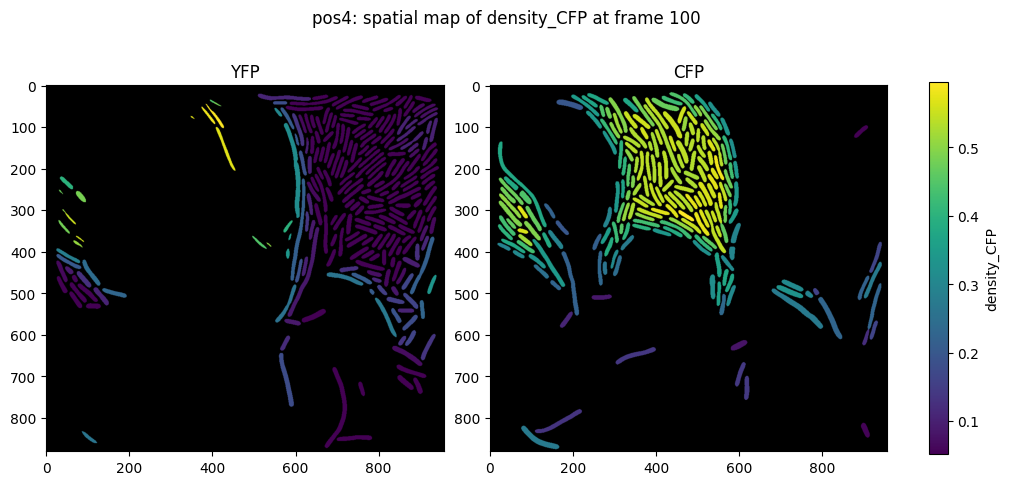

In [4]:
experiment.plot_selected_frame(100,"pos4")
experiment.plot_spatial_maps(frame=100,property_column="density_YFP", positions= "pos4")
experiment.plot_spatial_maps(frame=100,property_column="density_CFP", positions= "pos4")

***

midap-tools allows us to ignore empty space instead, this way densities are calculated in relation to each other. the sum will always be one. We can calculate neighborhood while ignoring empty space

We can do this will the following addition to the code

In [5]:
experiment.calculate_local_neighborhood(distance_threshold=50,neighborhood_prefix="density_normalized_", include_empty=False)
print(experiment)

Calculating neighborhoods of all channels in a radius of 50 px
Calculate neighborhoods for position pos1
Calculate neighborhoods for position pos2
Calculate neighborhoods for position pos3
Calculate neighborhoods for position pos4
Calculate neighborhoods for position pos5
Calculate neighborhoods for position pos6
FluidExperiment with name: example_experiment
Path: ../../data/midap-tools_example
6 positions: pos1, pos2, pos3, pos4, pos5, pos6
2 color channels: YFP, CFP
length of experiment is consistent: 143
experiment has consistent headers: Unnamed: 0, globalID, frame, labelID, trackID, lineageID, trackID_d1, trackID_d2, split, trackID_mother, first_frame, last_frame, area, edges_min_row, edges_min_col, edges_max_row, edges_max_col, intensity_max, intensity_mean, intensity_min, minor_axis_length, major_axis_length, x, y, density_YFP, density_CFP, density_normalized_YFP, density_normalized_CFP
Experiment has metadata:
         position   group          experiment  device_channel
positi

***

we now created two new data_columns, `density_normalized_YFP` and `density_normalized_CFP`

lets plot some spatial maps

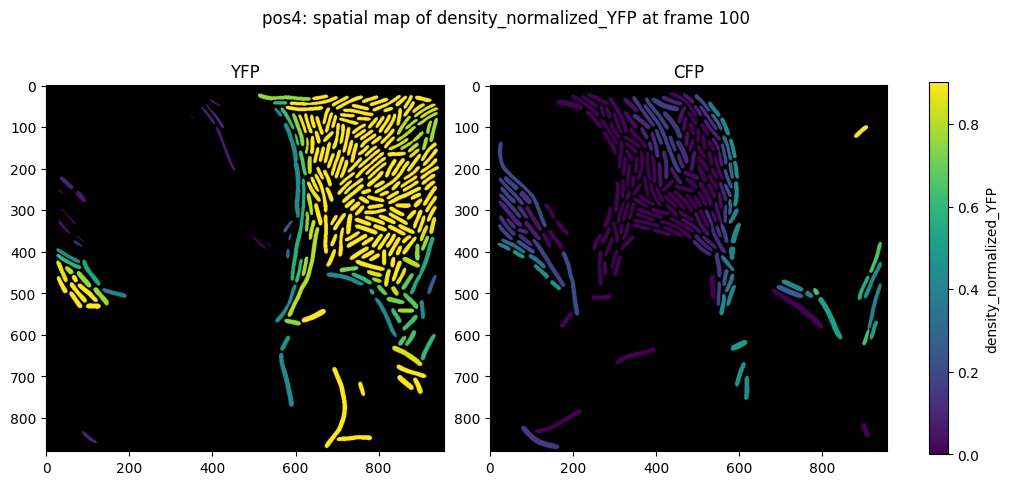

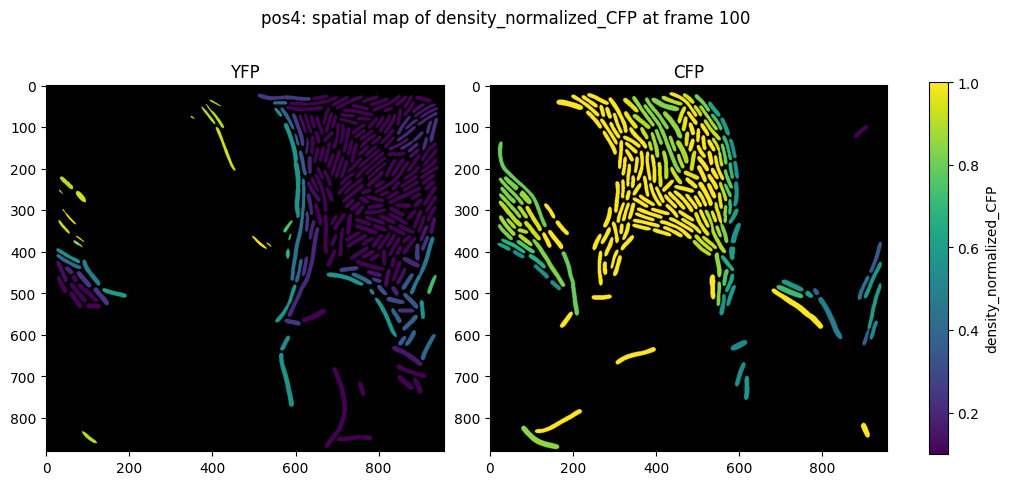

In [6]:
experiment.plot_spatial_maps(frame=100,property_column="density_normalized_YFP", positions= "pos4")
experiment.plot_spatial_maps(frame=100,property_column="density_normalized_CFP", positions= "pos4")

## Density dependen growth rate calculations

We may want to know if there is a dependency of growth rate on the local environment.

Midap tools includes methods to analyze density data

Lets first start by filtering the data, log transforming the major axis length, and calculateing the growth rate on this column

In [7]:
experiment.filter_data(column="trackID", min_occurences=5)
experiment.calculate_transform_data("major_axis_length")
experiment.calculate_growth_rate(integration_window=5,id_column="trackID",value_column="major_axis_length_log")

Filtering out trackID with less than 5 occurences
Filtering channel YFP at position pos1:
Filtering channel CFP at position pos1:
Filtering channel YFP at position pos2:
Filtering channel CFP at position pos2:
Filtering channel YFP at position pos3:
Filtering channel CFP at position pos3:
Filtering channel YFP at position pos4:
Filtering channel CFP at position pos4:
Filtering channel YFP at position pos5:
Filtering channel CFP at position pos5:
Filtering channel YFP at position pos6:
Filtering channel CFP at position pos6:
Calculate growth rate for trackID measured with major_axis_length_log over an integration window of 5


***

### Bin by density and createing a summary plot

next, we want to add bins that define different density ranges (low, medium and high). lets first plot a QC histogram to see the range of our densities within the entire experiment

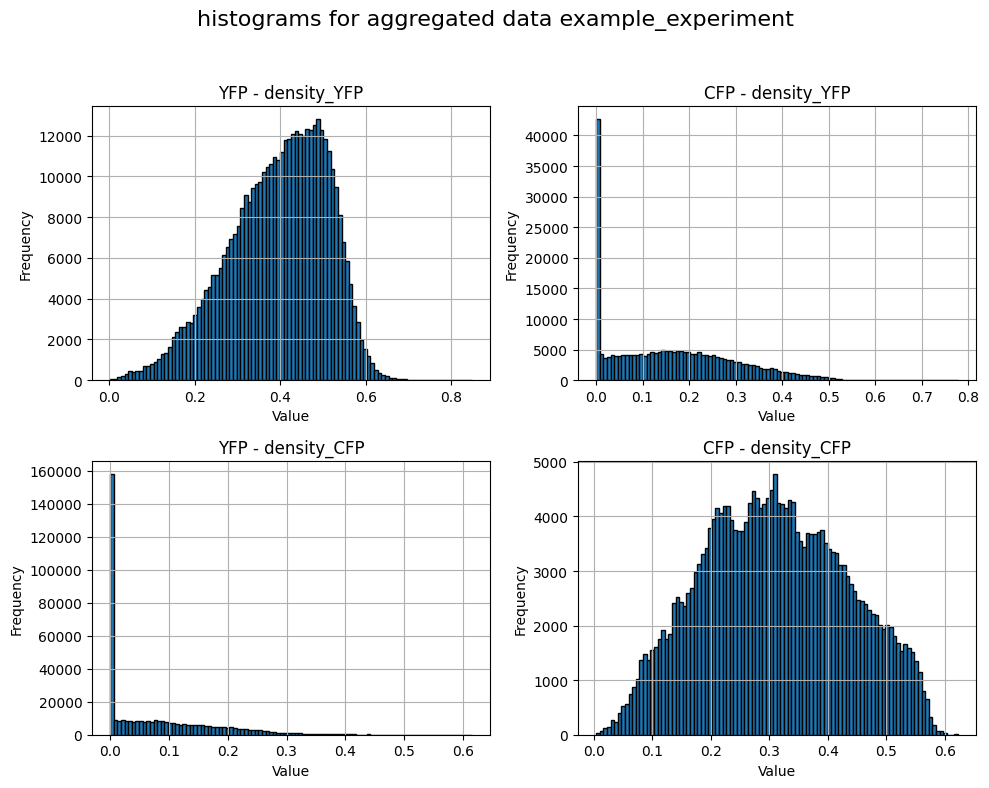

In [8]:
experiment.plot_qc_histograms(["density_YFP","density_CFP"],group_by= "experiment")

***

based on the distribution we can now decide what sensible bins might be

In this example we set cutoff 0.3 and 0.5 for YFP and 0.2 and 0.4 for CFP

To add bins we use:

In [9]:
experiment.add_bin_data_from_data(bin_data = {"1_low_YFP":(0,0.3), 
                                              "2_medium_YFP": (0.3,0.5), 
                                              "3_high_YFP": (0.5,1)},
                                  data_column = "density_YFP",
                                  bin_column_name= "bins_YFP")


Adding bin data to all positions and color channels based on density_YFP
Adding bin data to position pos1 and color channel YFP
Adding bin data to position pos1 and color channel CFP
Adding bin data to position pos2 and color channel YFP
Adding bin data to position pos2 and color channel CFP
Adding bin data to position pos3 and color channel YFP
Adding bin data to position pos3 and color channel CFP
Adding bin data to position pos4 and color channel YFP
Adding bin data to position pos4 and color channel CFP
Adding bin data to position pos5 and color channel YFP
Adding bin data to position pos5 and color channel CFP
Adding bin data to position pos6 and color channel YFP
Adding bin data to position pos6 and color channel CFP


*** 

And now, we can create a summary plot for growth rate by these bins:

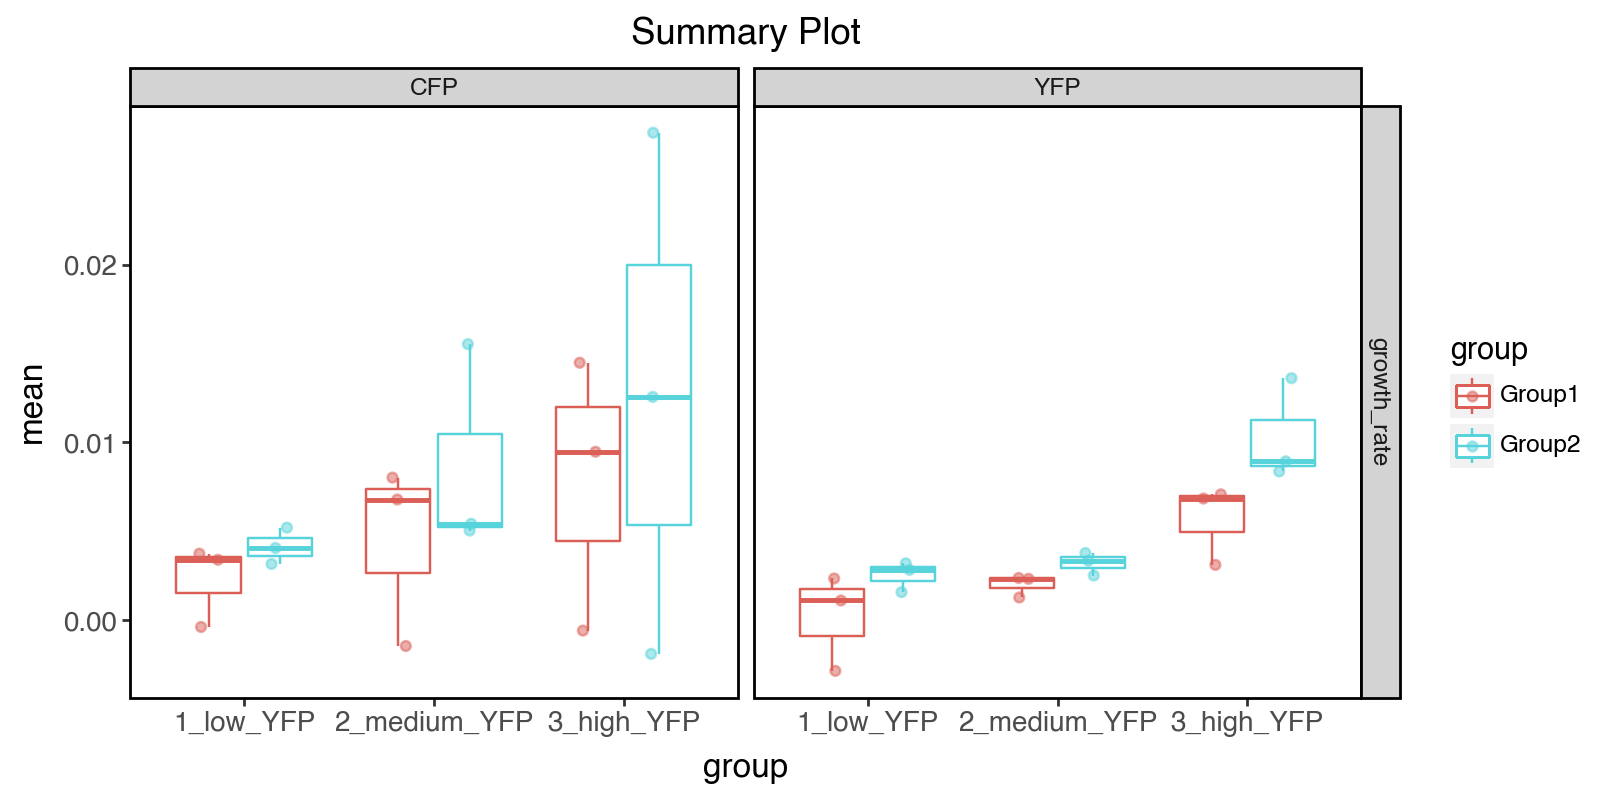

In [10]:
experiment.plot_data_summary(value_columns="growth_rate",use_bins=True, group_by="group",bin_column_name="bins_YFP")

### Analyze dependency of density on slope at each frame

midap-tools further allows you to run an indepth analysis that establishes at each frame how strongly the growth rate depends on a given density.
To access this type of analysis we can use:

Creating frame 0 for metric density_YFP and group YFP
Creating frame 1 for metric density_YFP and group YFP
Creating frame 2 for metric density_YFP and group YFP
Creating frame 3 for metric density_YFP and group YFP
Creating frame 4 for metric density_YFP and group YFP
Creating frame 5 for metric density_YFP and group YFP
Creating frame 6 for metric density_YFP and group YFP
Creating frame 7 for metric density_YFP and group YFP
Creating frame 8 for metric density_YFP and group YFP
Creating frame 9 for metric density_YFP and group YFP
Creating frame 10 for metric density_YFP and group YFP
Creating frame 11 for metric density_YFP and group YFP
Creating frame 12 for metric density_YFP and group YFP
Creating frame 13 for metric density_YFP and group YFP
Creating frame 14 for metric density_YFP and group YFP
Creating frame 15 for metric density_YFP and group YFP
Creating frame 16 for metric density_YFP and group YFP
Creating frame 17 for metric density_YFP and group YFP
Creating frame 18 fo

/Users/lukasv/SIS/github_midap-tools/midap-tools/src/fluid_experiment/fluid_experiment.py:1150: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.


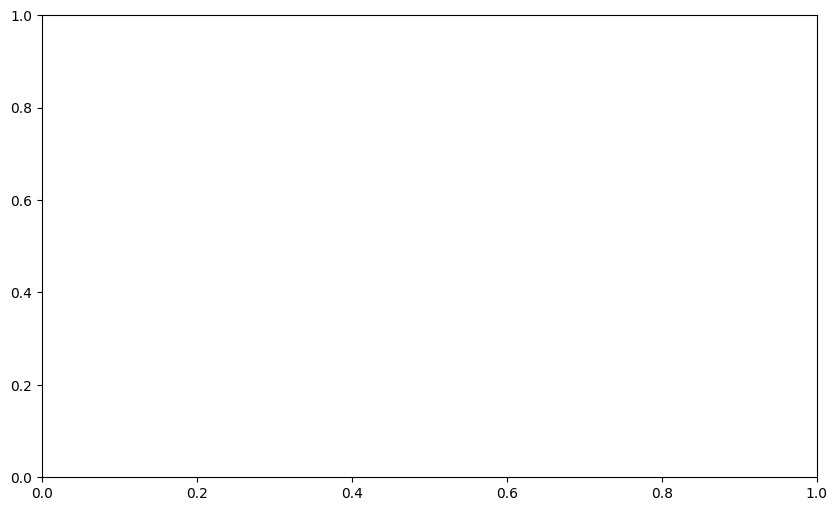

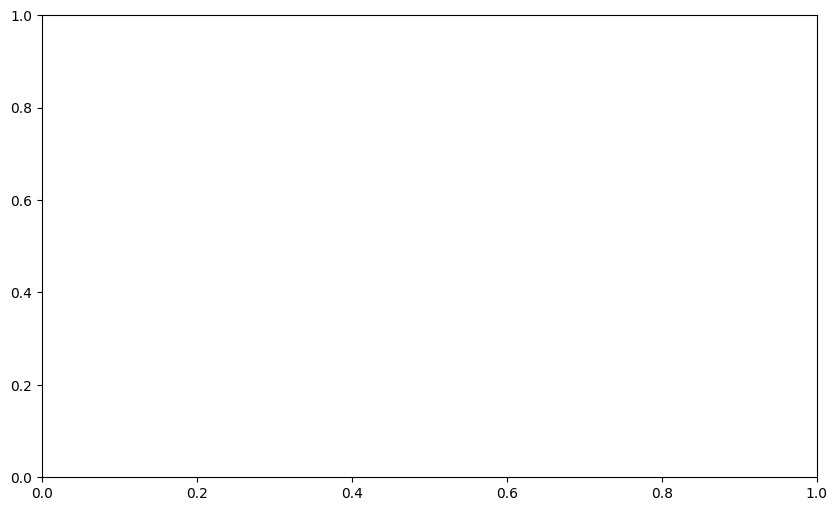

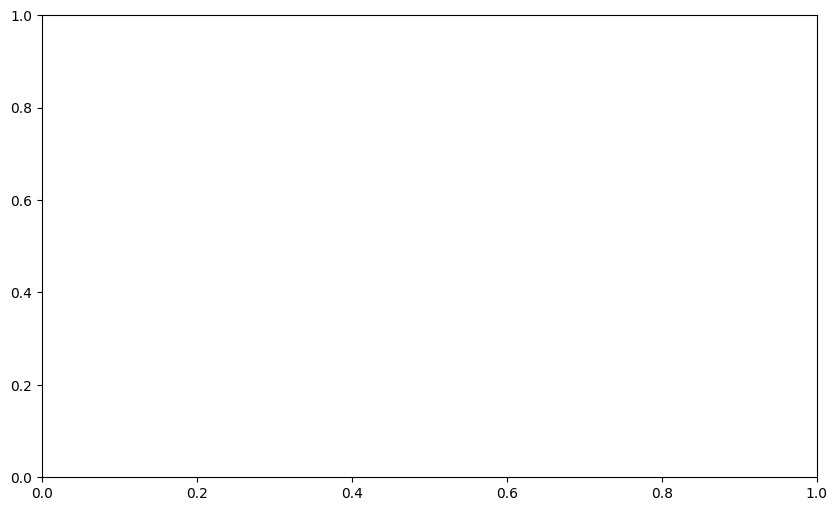

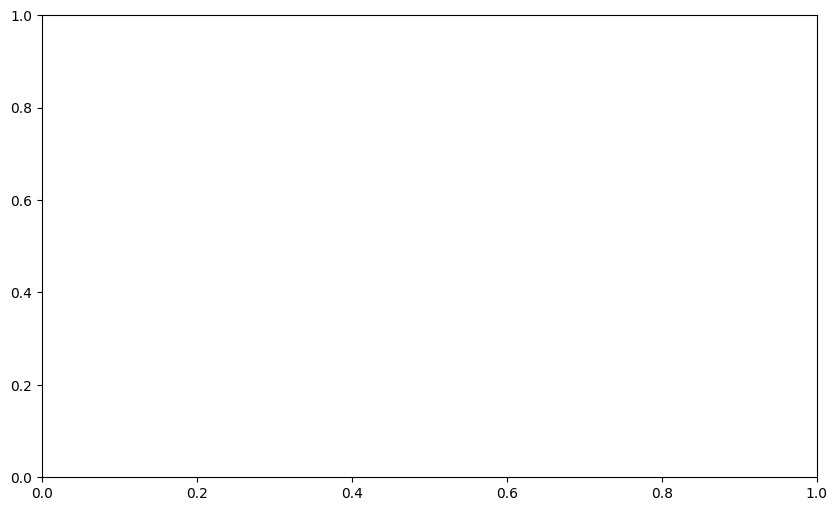

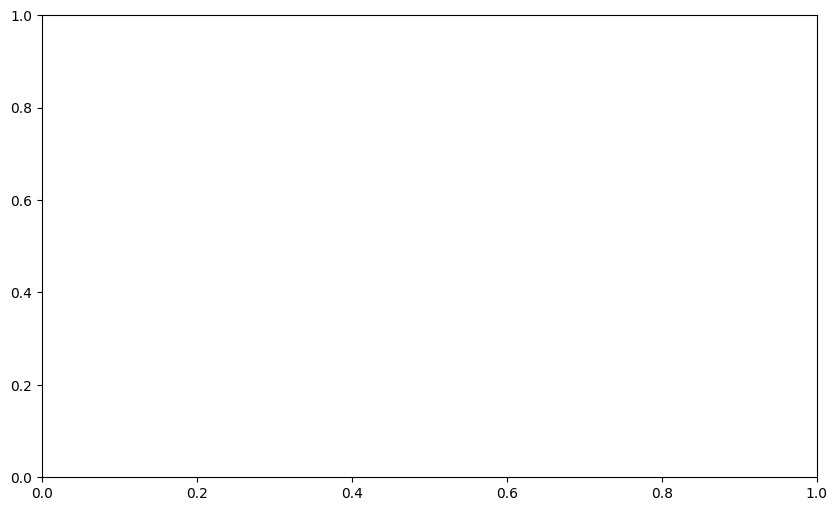

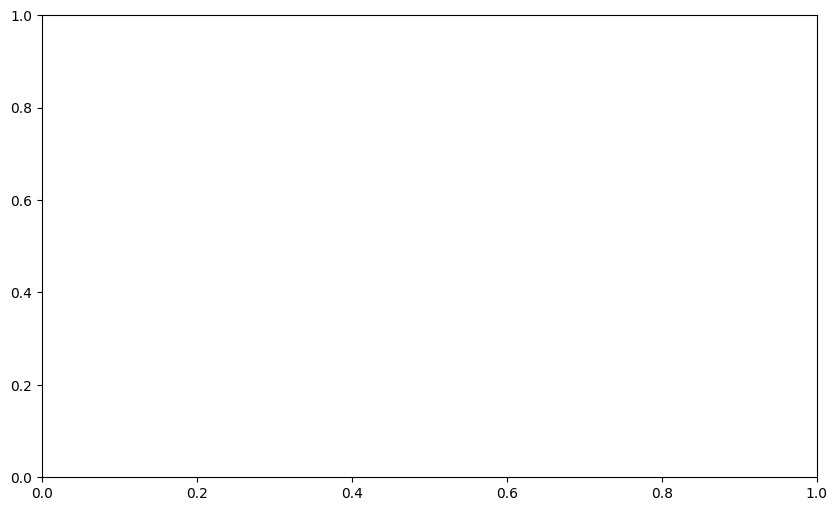

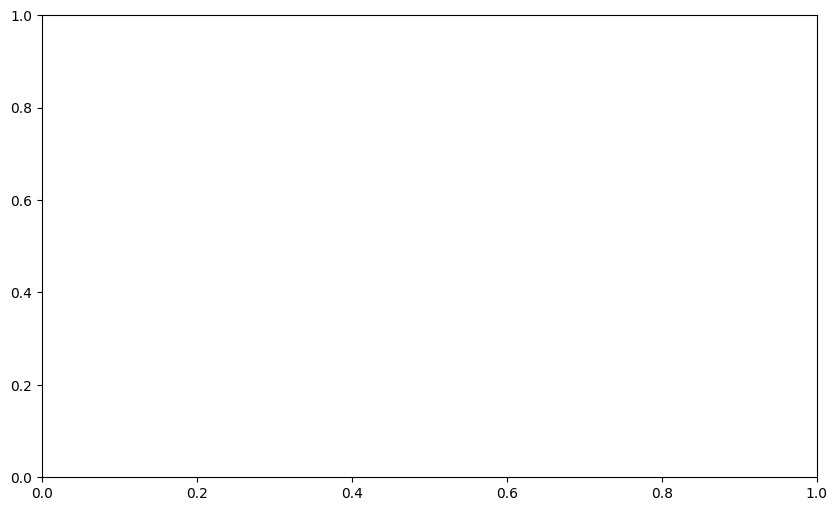

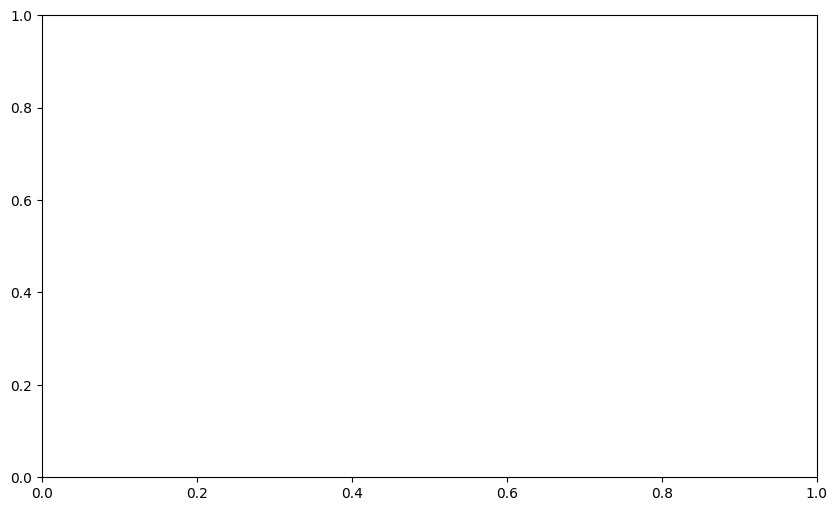

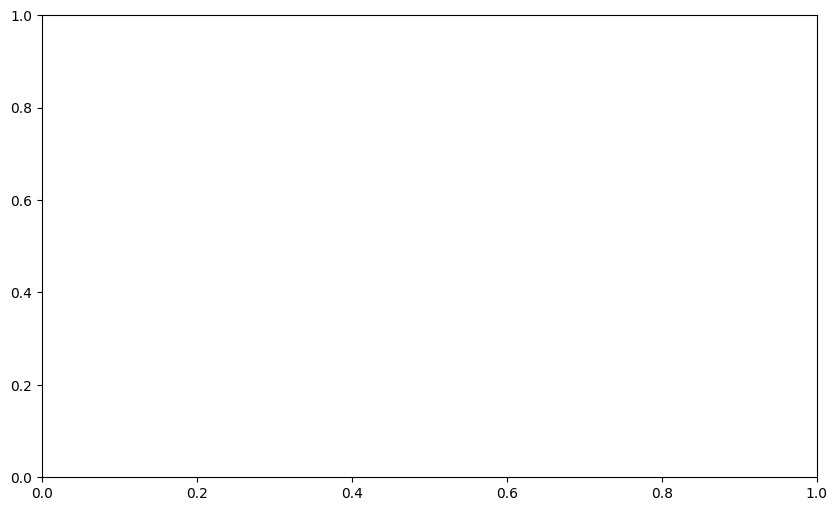

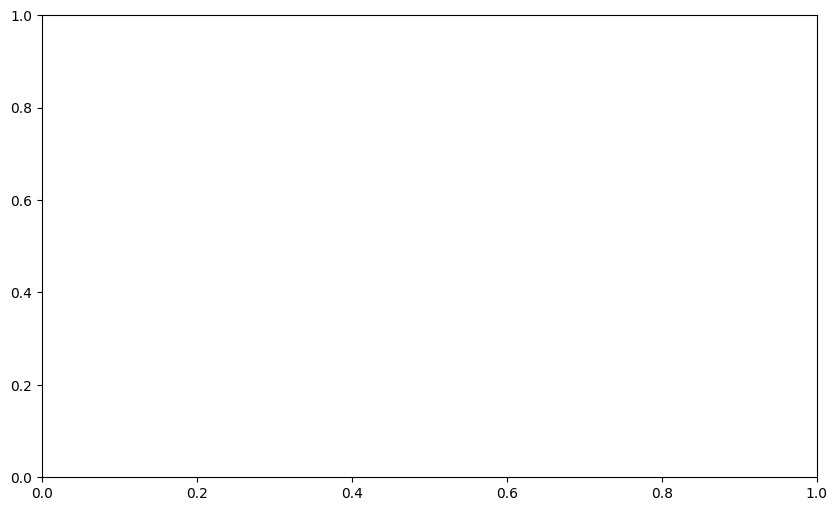

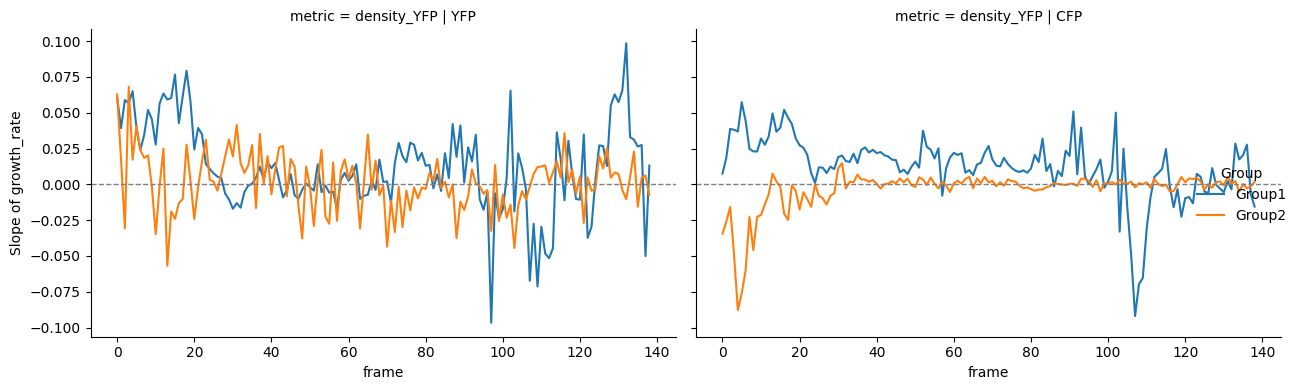

In [11]:
results = experiment.plot_xy_correlation_over_time(x_column= "density_YFP", y_column="growth_rate", group_by= "group", flip_grouping= True)

***

the corresponsing graph shows us at each frame if there is a positive or negative impact of denisty_YFP on the growth rate. This can be helpful for experiments where media switches change the positive or negative dependency of cells on each other.

In addition, the operation also created a number of gifs that show the raw data and the fitted line at each frame. They are placed in the same folder where the jupyter notebook is situated

This call also created a pandas dataframe that we assigned to results. If we need access to the analysis results, we can use:

In [12]:
results.head()

,time,slope,intercept,r2,group1,group2,metric
0,0,0.060641,0.000143,0.022888,YFP,Group1,density_YFP
1,0,0.062738,0.017084,0.012900,YFP,Group2,density_YFP
2,1,0.039254,0.007465,0.008998,YFP,Group1,density_YFP
3,1,0.017721,0.037817,0.001155,YFP,Group2,density_YFP
4,2,0.058836,-0.002567,0.017267,YFP,Group1,density_YFP
